# Predicton model: oscillator

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import epde.interface.interface as epde_alg
from epde.interface.prepared_tokens import CustomTokens, CacheStoredTokens

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams['figure.facecolor'] = 'white'
#plt.style.use('dark_background')

In [77]:
from datetime import date, timedelta, datetime

datify = lambda x: datetime.strptime(x, '%Y-%m-%d')
textify = lambda x: x.strftime('%Y-%m-%d')

def read_cli(path):
    temp_ts = pd.read_csv(path)
    temp_ts['date'] = pd.to_datetime(temp_ts['date'])
    temp_ts.sort_values(by='date', inplace=True, ignore_index=True)
    temp_ts.set_index('date', inplace=True)
    return temp_ts

def read_news(path):
    temp_ts = pd.read_csv(path, sep=',', on_bad_lines='skip')
    temp_ts.rename(columns={"Unnamed: 0": "date"}, inplace=True)
    temp_ts['date'] = pd.to_datetime(temp_ts['date'])
    temp_ts.sort_values(by='date', inplace=True, ignore_index=True)
    temp_ts.set_index('date', inplace=True)
    return temp_ts

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

news = read_news('../DATA-PROCESSING/PROCESSED-DATA/TOPICS.csv').iloc[:,2:]
cli = read_cli('../DATA-PROCESSING/PROCESSED-DATA/TRANS/MACRO-TRANS.csv')

for col in cli.columns:
    cli[col] = seasonal_decompose(cli[col],
                                  model='additive',
                                  period=14,
                                  two_sided=False,
                                  extrapolate_trend='freq').trend

news = news.reindex(news.index.union(cli.index)).interpolate(method='time')
news = news.reindex(cli.index)

news[]

print(f"News dates:\t{news.index[0]}\t{news.index[1]}\t...\t{news.index[-1]}")
print(f"Cli dates:\t{cli.index[0]}\t{cli.index[1]}\t...\t{cli.index[-1]}")

News dates:	2018-01-01 00:00:00	2018-01-02 00:00:00	...	2022-08-15 00:00:00
Cli dates:	2018-01-01 00:00:00	2018-01-02 00:00:00	...	2022-08-15 00:00:00


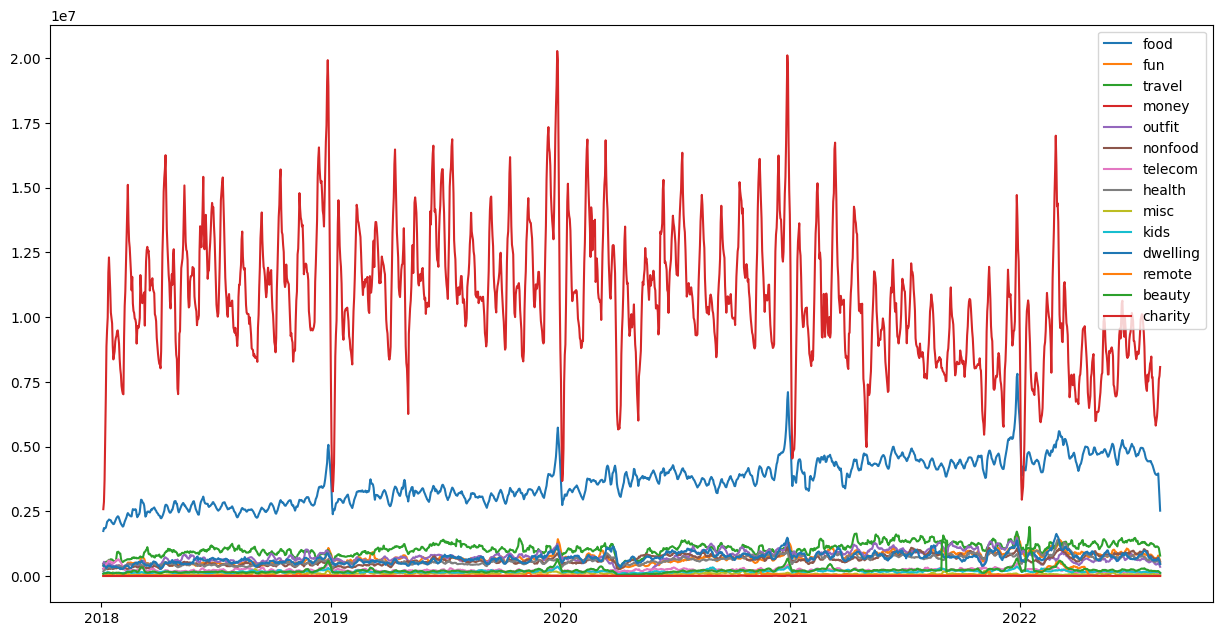

In [24]:
plt.plot(cli);
plt.legend(cli.columns);

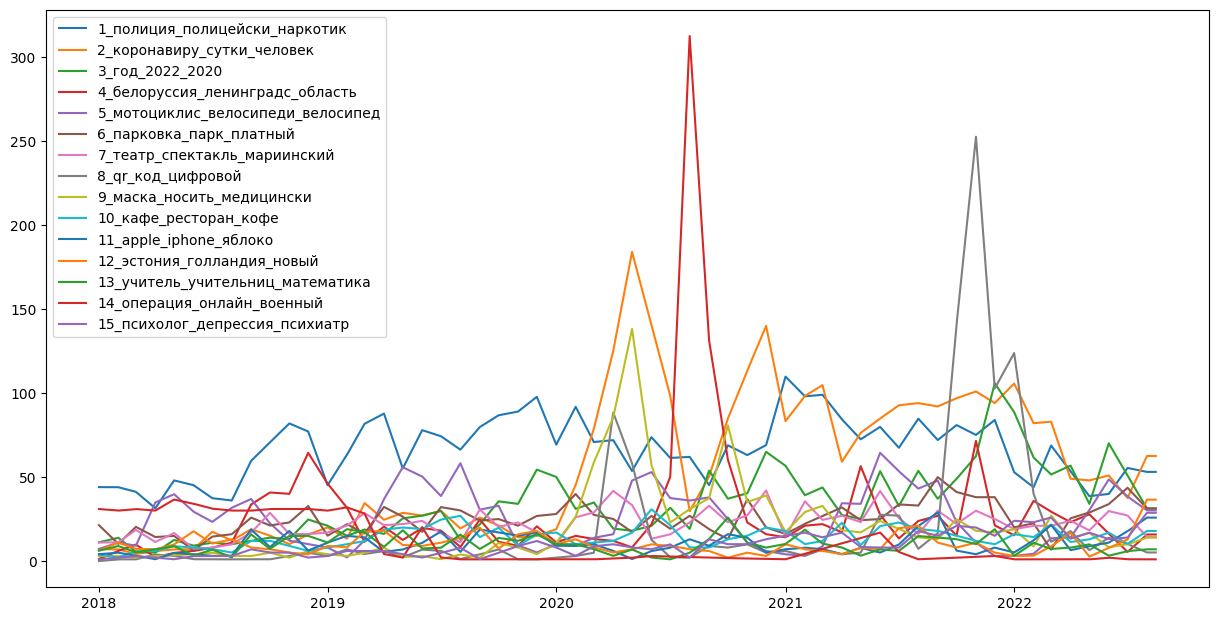

In [25]:
num = 15
plt.plot(news.iloc[:,:num]);
plt.legend(news.columns[:num]);

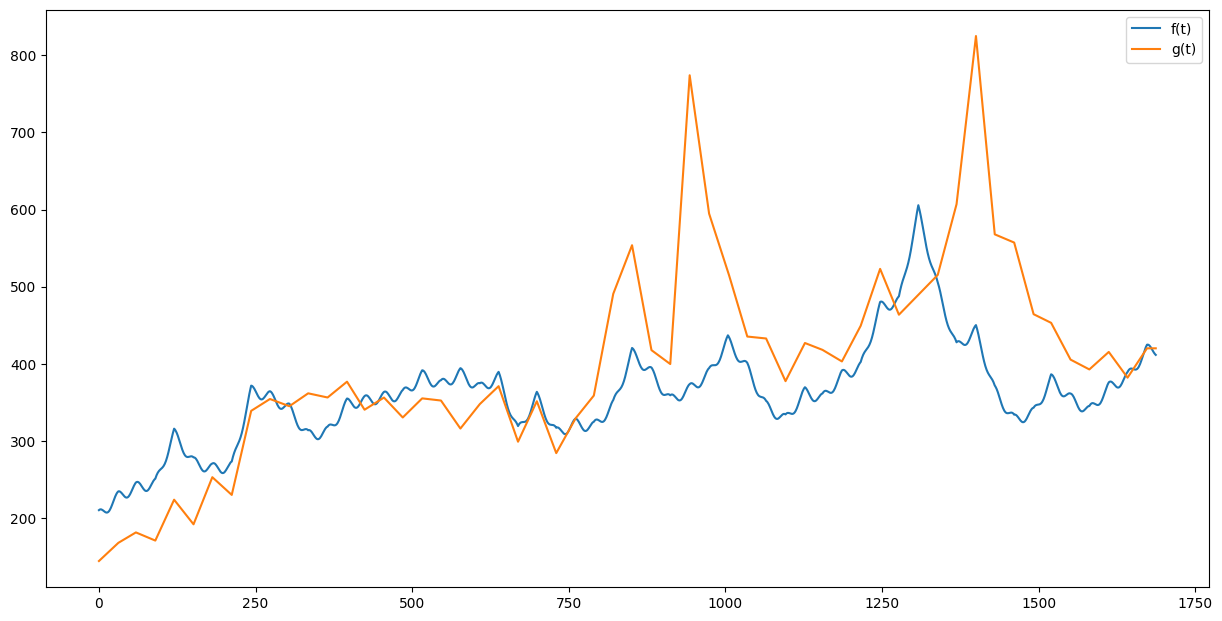

In [45]:
def f_func(news_fw, sin_w=0.5, bias=0.0):
    assert (sin_w <= 1 and sin_w >= 0), "Weight of sin function is out of bounds [0, 1]!"
    news_fw = np.array(news_fw)
    news_fw /= news_fw.mean() # normalize weights
    weights = pd.Series(news_fw, index=news.columns)
    wn = (news * weights).sum(1)
    wn = wn.reset_index(drop=True)
    
    sin_func = [np.cos(2*np.pi*i/30.437) * wn.std() + wn.mean() for i in range(len(wn))]
    sin_df = news.copy()
    sin_df['sin'] = sin_func
    sin_df = sin_df['sin']
    sin_df = sin_df.reset_index(drop=True)
    
    ans = (1 - sin_w) * wn + sin_w * sin_df + bias
    return ans

def g_func(news_gw, bias=0.0):
    news_gw = np.array(news_gw)
    news_gw /= news_gw.mean() # normalize weights
    weights = pd.Series(news_gw, index=news.columns)
    wn = (news * weights).sum(1)
    wn = wn.reset_index(drop=True)
    return wn + bias

f_cur = f_func([np.random.rand() for i in range(len(news.columns))], sin_w=0.1)
g_cur = g_func([np.random.rand() for i in range(len(news.columns))])

plt.plot(f_cur, label="f(t)")
plt.plot(g_cur, label="g(t)")
plt.legend();

Oscillator function:
$$X'' + aX' + bX = f(t)$$
where $X$ is the time series, $X'$ and $X''$ are its time derivatives, $a$ and $b$ are model parameters.

If $Z = X'$, then:
$$\begin{cases}
X'(t) = Z(t) + g(t) \\
Z'(t) = f(t) - aZ(t) - bX
\end{cases} \qquad g(t) \equiv 0$$

Vectorially speaking:
$$\frac{d}{dt} \begin{bmatrix} X \\ Z \end{bmatrix} = 
\begin{bmatrix} 0 & 1 \\ -b & -a \end{bmatrix} \cdot
\begin{bmatrix} X \\ Z \end{bmatrix} + 
\begin{bmatrix} g(t) \\ f(t) \end{bmatrix} \qquad g(t) \equiv 0$$

In this model, however, $g(t) \neq 0$, thus:
$$\underbrace{\frac{d}{dt} \begin{bmatrix} X \\ Z \end{bmatrix}}_{Y'} = 
\underbrace{\begin{bmatrix} 0 & 1 \\ -b & -a \end{bmatrix}}_{A} \cdot
\underbrace{\begin{bmatrix} X \\ Z \end{bmatrix}}_{Y} + 
\underbrace{\begin{bmatrix} g(t) \\ f(t) \end{bmatrix}}_{B}$$
$$Y' = A \cdot Y + B(t)$$

In [72]:
from scipy.integrate import odeint
def model(Y, t, a, b, g, f):
    return np.array([Y[1] + g[t],
                     f[t] - a*Y[1] - b*Y[0]])

t = f_cur.index.to_list()

Y0 = np.array([0.0, 0.0])
sol = odeint(model, Y0, t, args=(0.037, 0.002, g_cur, f_cur))

KeyError: 5.792561750481989e-07